In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feat import Detector
import librosa
from scipy.signal import resample as sci_resample
from mtrf.model import TRF
import seaborn as sns

#### Helper functions

In [3]:
def get_rms_envelope(audio_file, reqd_sr):
    stim, sr = librosa.load(audio_file)

    # Compute RMS 
    rms_win = 0.01 # 10ms
    rms_hop = 1/reqd_sr # hop by eeg sampling rate
    rms = librosa.feature.rms(y=stim, frame_length=int(sr*rms_win), hop_length=int(sr*rms_hop))
    rms_sr = 1/rms_hop # the rms time series is sampled with period rms_hop
    rms=rms[0]

    return rms


def resample_signal(signal, duration, reqd_sr, num_samples, pad_before):
    signal_resampled = sci_resample(signal, len(np.arange(0, duration, 1/reqd_sr)))
        
    pad_after = num_samples - (len(signal_resampled)+pad_before)
    signal_padded = np.pad(signal_resampled, pad_width=(pad_before,pad_after))

    return signal_padded


def analyse_videos( input_file, 
                    target_file, 
                    skip_frames=10, 
                    # batch_size=900, 
                    num_workers=16, 
                    pin_memory=False, 
                    n_jobs = 12,
                    face_model = "retinaface",
                    landmark_model = "mobilefacenet",
                    au_model = 'xgb',
                    emotion_model = "resmasknet",
                    facepose_model = "img2pose",
                    device = "cuda"):
    #New detector
    detector = Detector(
        face_model = face_model,
        landmark_model = landmark_model,
        au_model = au_model,
        emotion_model = emotion_model,
        facepose_model = facepose_model,
        device = device
    )

    video_prediction = detector.detect_video(input_file
                                            , skip_frames = skip_frames
                                            # , batch_size = batch_size
                                            , num_workers = num_workers
                                            , pin_memory = pin_memory
                                            , n_jobs = n_jobs)

    video_prediction.to_csv(target_file)


def get_aus(df, condition):
    counter = 0
    for i in range(len(df)):
        filepath = df.iloc[i]['VideoPath']
        disp_dyad = df.iloc[i]['DisplayedDyad']
        aus_filepath = f'./data/aus_pure/{condition}/{disp_dyad}_{filepath.split(os.sep)[-1][:-4]}_aus.csv'
        print(f'{counter}. ', filepath)
        analyse_videos(filepath, aus_filepath)
        counter += 1

In [4]:
df = pd.read_csv('./stim/all_trials_dispDyad.csv')

df_va = df[df['Modality'] == 'va']
df_va_trues = df_va[df_va['Condition'] == 'TRUE']
df_va_fakes = df_va[df_va['Condition'] != 'TRUE']

#### Format training data for TRF

In [5]:
sr = 30
min_time_lag = -1                       # in seconds
max_time_lag = 26                        # in seconds
pad_before = np.abs(sr*min_time_lag)
num_samples = (sr*max_time_lag)+(pad_before)

In [6]:
rms_all = []
expressions_all = []

for i in range(len(df_va_trues)):
    filepath = df_va_trues.iloc[i]['VideoPath']
    disp_dyad = df_va_trues.iloc[i]['DisplayedDyad']
    duration = df_va_trues.iloc[i]['Duration']
    aus_filepath = f'./data/aus_pure/true/{disp_dyad}_{filepath.split(os.sep)[-1][:-4]}_aus.csv'

    rms = get_rms_envelope(df_va_trues.iloc[i]['AudioPath'], sr)
    rms = resample_signal(rms, duration, sr, num_samples, pad_before)

    df = pd.read_csv(aus_filepath)
    anger = df['anger'].to_numpy()
    anger = resample_signal(anger, duration, sr, num_samples, pad_before)
    disgust = df['disgust'].to_numpy()
    disgust = resample_signal(disgust, duration, sr, num_samples, pad_before)
    fear = df['fear'].to_numpy()
    fear = resample_signal(fear, duration, sr, num_samples, pad_before)
    happiness = df['happiness'].to_numpy()
    happiness = resample_signal(happiness, duration, sr, num_samples, pad_before)
    sadness = df['sadness'].to_numpy()
    sadness = resample_signal(sadness, duration, sr, num_samples, pad_before)
    surprise = df['surprise'].to_numpy()
    surprise = resample_signal(surprise, duration, sr, num_samples, pad_before)
    neutral = df['neutral'].to_numpy()
    neutral = resample_signal(neutral, duration, sr, num_samples, pad_before)
    
    expressions = np.column_stack((anger, disgust, fear, happiness, sadness, surprise, neutral))
    rms_all.append(rms)
    expressions_all.append(expressions)


# expressions_all = np.asarray(expressions_all)
# expressions_all_reshaped = []
# for expression in expressions_all:
#     expressions_all_reshaped.append(np.reshape(expression, (-1, 1)))

rms_all = np.asarray(rms_all)
rms_all_reshaped = []
for el in rms_all:
    rms_all_reshaped.append(np.reshape(el, (-1, 1)))

#### Train TRF

In [7]:
trf = TRF(direction=1)
# regularization = np.logspace(-1, 6, 20)
# [correlation, error] = trf.train(rms_all_reshaped, smiles_all_reshaped, 30, tmin=-1, tmax=26, k=-1, regularization=regularization)
trf.train(rms_all_reshaped, expressions_all, sr, tmin=min_time_lag, tmax=max_time_lag, regularization=1)

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.semilogx(regularization, correlation, color='c')
# ax2.semilogx(regularization, error, color='m')
# ax1.set(xlabel='Regularization value', ylabel='Correlation coefficient')
# ax2.set(ylabel='Mean squared error')
# ax1.axvline(regularization[np.argmin(error)], linestyle='--', color='k')
# plt.show()

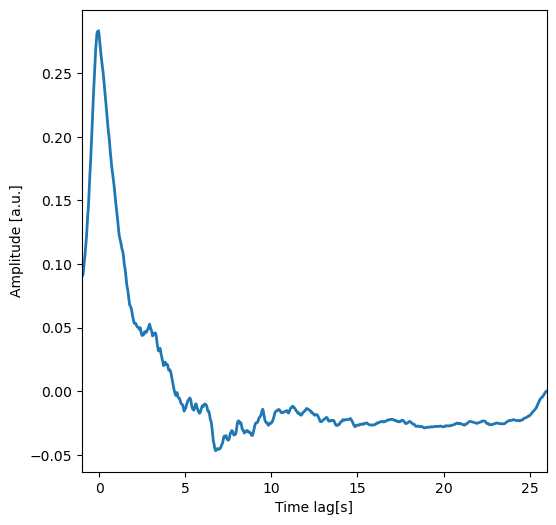

In [8]:
trf.plot(channel='avg', feature=None, kind='line');

#### Prediction

In [9]:
dyad_col = []
stim_col = []
time_col = []
actual_col = []
pred_col = []
corr_col = []
error_col = []

for j in range(len(df_va_fakes)):
    input_rms = get_rms_envelope(df_va_fakes.iloc[j]['AudioPath'], sr)
    input_rms = resample_signal(input_rms, duration, sr, num_samples, pad_before)
    input_rms = np.asarray(input_rms)
    input_rms_reshaped = np.reshape(input_rms, (-1, 1))

    # Actual
    filepath = df_va_fakes.iloc[j]['VideoPath']
    disp_dyad = df_va_fakes.iloc[j]['DisplayedDyad']
    speaker_extract = df_va_fakes.iloc[j]['SpeakerExtract']
    listener_extract = df_va_fakes.iloc[j]['ListenerExtract']
    duration = df_va_fakes.iloc[j]['Duration']
    aus_filepath = f'./data/aus_pure/fake/{disp_dyad}_{filepath.split(os.sep)[-1][:-4]}_aus.csv'

    if os.path.exists(aus_filepath):
        df = pd.read_csv(aus_filepath)
        anger = df['anger'].to_numpy()
        anger = resample_signal(anger, duration, sr, num_samples, pad_before)
        disgust = df['disgust'].to_numpy()
        disgust = resample_signal(disgust, duration, sr, num_samples, pad_before)
        fear = df['fear'].to_numpy()
        fear = resample_signal(fear, duration, sr, num_samples, pad_before)
        happiness = df['happiness'].to_numpy()
        happiness = resample_signal(happiness, duration, sr, num_samples, pad_before)
        sadness = df['sadness'].to_numpy()
        sadness = resample_signal(sadness, duration, sr, num_samples, pad_before)
        surprise = df['surprise'].to_numpy()
        surprise = resample_signal(surprise, duration, sr, num_samples, pad_before)
        neutral = df['neutral'].to_numpy()
        neutral = resample_signal(neutral, duration, sr, num_samples, pad_before)
        
        expressions = np.column_stack((anger, disgust, fear, happiness, sadness, surprise, neutral))
        
        dyad_col.append(np.repeat(disp_dyad, num_samples))
        stim = str(disp_dyad)+'_'+filepath.split(os.sep)[-1][:-6]
        stim_col.append(np.repeat(stim, num_samples))
        time_col.append(np.arange(min_time_lag, max_time_lag, 1/sr))
        actual_col.append(expressions)
        
        # Predicted
        [prediction, correlation, error] = trf.predict(input_rms_reshaped, expressions, average=False)
        pred_col.append(np.asanyarray(prediction)[0])
        corr_col.append(np.asanyarray([correlation]*num_samples))
        error_col.append(np.asanyarray([error]*num_samples))

        # sns.lineplot(y=np.asanyarray(input_rms_reshaped).flatten(), x=np.arange(min_time_lag, max_time_lag, 1/sr))
        # sns.lineplot(y=np.asanyarray(prediction).flatten(), x=np.arange(min_time_lag, max_time_lag, 1/sr))
        # plt.ylabel('RMS')
        # plt.show()

In [10]:
print(actual_col[0].shape)
print(pred_col[0].shape)
print(corr_col[0].shape)
print(error_col[0].shape)

(810, 7)
(810, 7)
(810, 7)
(810, 7)


In [11]:
expr_list = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
col_dict = {'Dyad': np.asanyarray(dyad_col).flatten(),
            'Stim': np.asanyarray(stim_col).flatten(),
            'Time': np.asanyarray(time_col).flatten()}

for i in range(7):
    col_dict[f'Actual {expr_list[i]}'] = np.asarray(actual_col)[:, :, i].flatten()
    col_dict[f'Predicted {expr_list[i]}'] = np.asarray(pred_col)[:, :, i].flatten()
    col_dict[f'Correlation {expr_list[i]}'] = np.asarray(corr_col)[:, :, i].flatten()
    col_dict[f'Error {expr_list[i]}'] = np.asarray(error_col)[:, :, i].flatten()

df_trf = pd.DataFrame(col_dict)
df_trf

,Dyad,Stim,Time,Actual Anger,Predicted Anger,Correlation Anger,Error Anger,Actual Disgust,Predicted Disgust,Correlation Disgust,...,Correlation Sadness,Error Sadness,Actual Surprise,Predicted Surprise,Correlation Surprise,Error Surprise,Actual Neutral,Predicted Neutral,Correlation Neutral,Error Neutral
0,1,1_1_2_,-1.000000,0.0,0.011145,0.791319,0.000068,0.0,0.009860,0.263748,...,0.741494,0.000280,0.0,0.000633,0.164830,0.000041,0.0,0.160132,0.868800,0.241033
1,1,1_1_2_,-0.966667,0.0,0.011165,0.791319,0.000068,0.0,0.009828,0.263748,...,0.741494,0.000280,0.0,0.000648,0.164830,0.000041,0.0,0.160205,0.868800,0.241033
2,1,1_1_2_,-0.933333,0.0,0.011174,0.791319,0.000068,0.0,0.009816,0.263748,...,0.741494,0.000280,0.0,0.000657,0.164830,0.000041,0.0,0.160255,0.868800,0.241033
3,1,1_1_2_,-0.900000,0.0,0.011188,0.791319,0.000068,0.0,0.009799,0.263748,...,0.741494,0.000280,0.0,0.000669,0.164830,0.000041,0.0,0.160329,0.868800,0.241033
4,1,1_1_2_,-0.866667,0.0,0.011226,0.791319,0.000068,0.0,0.009748,0.263748,...,0.741494,0.000280,0.0,0.000701,0.164830,0.000041,0.0,0.160496,0.868800,0.241033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79375,60,60_55_3_59_2_,25.833333,0.0,-0.007077,0.479704,0.001150,0.0,-0.005065,0.336902,...,0.523071,0.003774,0.0,-0.000114,0.303367,0.008681,0.0,-0.078509,0.666013,0.071421
79376,60,60_55_3_59_2_,25.866667,0.0,-0.007011,0.479704,0.001150,0.0,-0.005033,0.336902,...,0.523071,0.003774,0.0,-0.000118,0.303367,0.008681,0.0,-0.077825,0.666013,0.071421
79377,60,60_55_3_59_2_,25.900000,0.0,-0.006929,0.479704,0.001150,0.0,-0.004994,0.336902,...,0.523071,0.003774,0.0,-0.000119,0.303367,0.008681,0.0,-0.077029,0.666013,0.071421
79378,60,60_55_3_59_2_,25.933333,0.0,-0.006831,0.479704,0.001150,0.0,-0.004948,0.336902,...,0.523071,0.003774,0.0,-0.000118,0.303367,0.008681,0.0,-0.076078,0.666013,0.071421


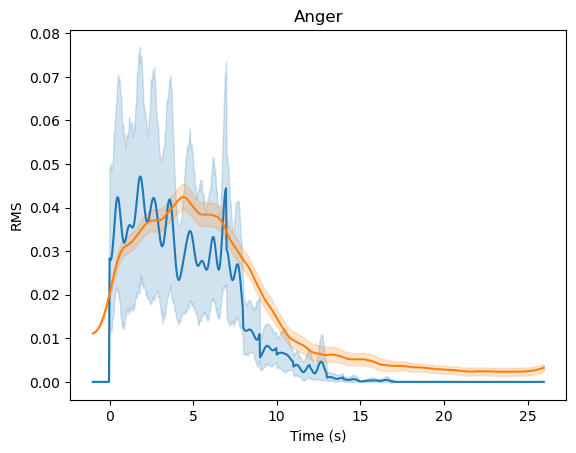

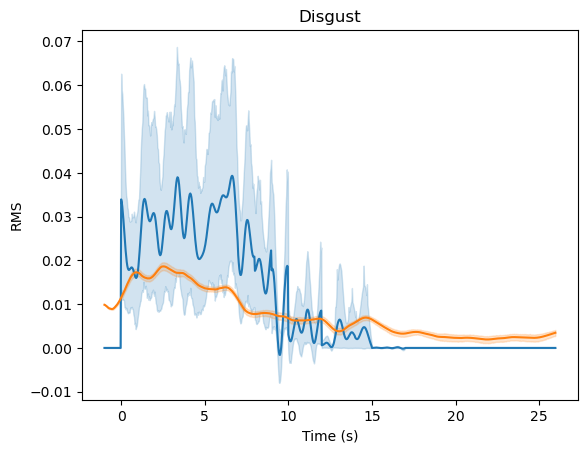

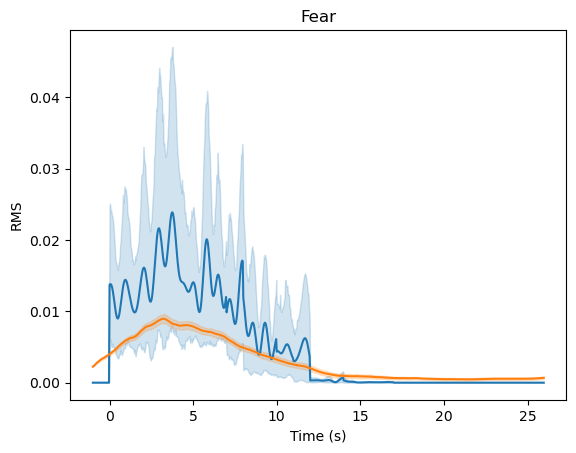

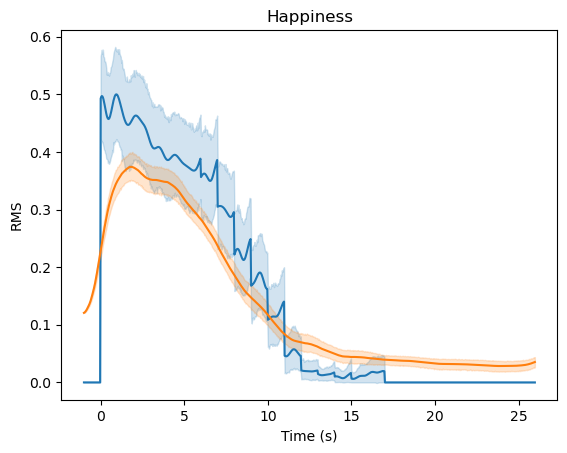

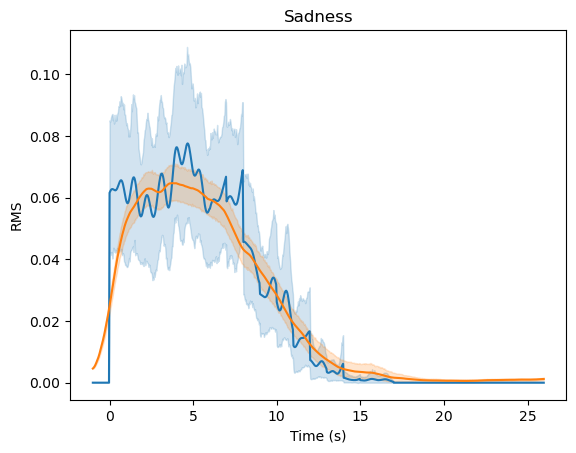

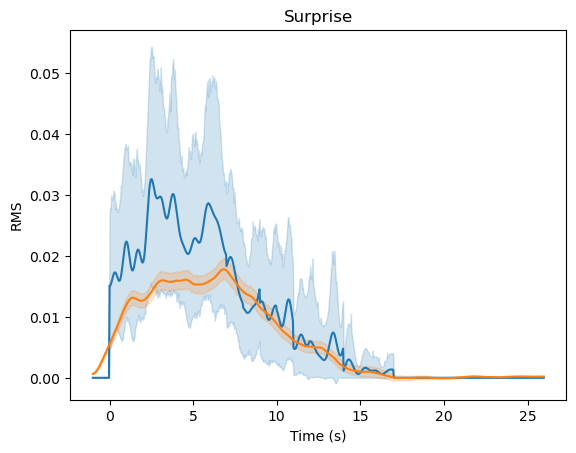

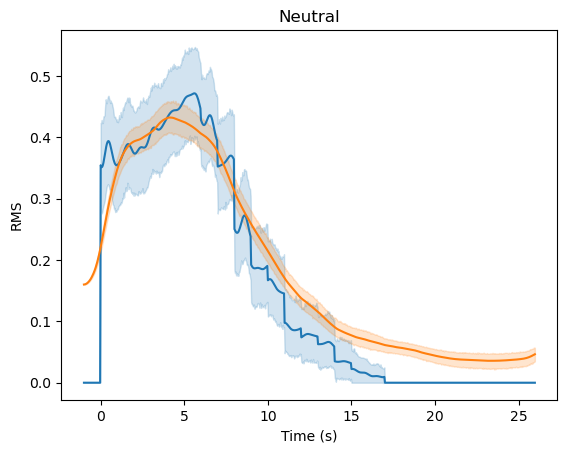

In [15]:
for expr in expr_list:
    sns.lineplot(data=df_trf, y=f'Actual {expr}', x='Time', errorbar='ci')
    sns.lineplot(data=df_trf, y=f'Predicted {expr}', x='Time', errorbar='ci')
    plt.ylabel('RMS')
    plt.xlabel('Time (s)')
    plt.title(expr)
    plt.show()

In [ ]:
df_trf_pred = df_trf.groupby(['Dyad']).agg({'Correlation': 'mean', 'Error': 'mean'})
df_trf_pred

In [ ]:
z_vals = np.arctanh(df_trf_pred['Correlation'].to_numpy())
avg_z = np.mean(z_vals)
r = np.tanh(avg_z)
print(r)